In [118]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/misclassified-models/cb_model.h5
/kaggle/input/misclassified-models/rf_model.h5
/kaggle/input/misclassified-models/svm_model.h5
/kaggle/input/trained-models/finalized_model_svm.h5
/kaggle/input/trained-models/finalized_model_nb.h5
/kaggle/input/trained-models/finalized_model_rf.h5
/kaggle/input/trained-models/finalized_model_cb.h5
/kaggle/input/misclassified-dataset/nb_misclassified.csv
/kaggle/input/misclassified-dataset/lg_misclassified.csv
/kaggle/input/misclassified-dataset/svm_misclassified.csv
/kaggle/input/dataset-with-class-label/allTweets.csv
/kaggle/input/all-covid19-vaccines-tweets/vaccination_all_tweets.csv


### Imports

In [119]:
import re
import string
import nltk
import pickle
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as ctb
plt.rc('figure',figsize=(17,13))
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
from plotly.subplots import make_subplots
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import datetime
import warnings
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer #  import TF-idf vectorizer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier # import Random forest from sklearn
from sklearn.naive_bayes import MultinomialNB # import Multinomial Naive Bayes model from sklearn.naive_bayes
from sklearn.svm import LinearSVC # import SVC model from sklearn.svm
#warnings.filterwarnings("ignore")
#print("Library Setup Complete.")

### Reading the Dataset

In [120]:
# Reading Data
vaccine_filepath = '../input/all-covid19-vaccines-tweets/vaccination_all_tweets.csv'
vaccine_data = pd.read_csv(vaccine_filepath)
print("Read Complete.")

Read Complete.


In [121]:
# Examining statistics
vaccine_data.describe()

,id,user_followers,user_friends,user_favourites,retweets,favorites
count,2.282070e+05,2.282070e+05,228207.000000,2.282070e+05,228207.000000,228207.000000
mean,1.407541e+18,9.605393e+04,986.736204,1.210417e+04,2.489284,10.819020
std,2.908485e+16,8.389053e+05,5293.500468,3.908233e+04,51.079821,199.527693
min,1.337728e+18,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,1.381940e+18,5.500000e+01,27.000000,5.700000e+01,0.000000,0.000000
50%,1.408133e+18,3.280000e+02,229.000000,9.960000e+02,0.000000,0.000000
75%,1.428688e+18,1.521000e+03,794.000000,7.300000e+03,1.000000,2.000000
max,1.463251e+18,1.635305e+07,582461.000000,1.299600e+06,12294.000000,54017.000000


In [122]:
# Determining data types
vaccine_data.dtypes

id                   int64
user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
retweets             int64
favorites            int64
is_retweet            bool
dtype: object

## Pre-Processing of data

In [123]:
# Lowercase
vaccine_data['text'] = vaccine_data['text'].str.lower()

In [124]:
#removing link suffixes 
vaccine_data['text'] = vaccine_data['text'].apply(lambda x:re.sub(r"http\S+", "", x))

In [125]:
# Punctuation Removal
punctuation_removal = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', punctuation_removal))
vaccine_data["text"] = vaccine_data["text"].apply(lambda text: remove_punctuation(text))

In [126]:
# Single character and double space removal
vaccine_data["text"] = vaccine_data["text"].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
vaccine_data["text"] = vaccine_data["text"].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [127]:
# Stopword Removal
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

vaccine_data["text"] = vaccine_data["text"].apply(lambda text: remove_stopwords(text))

In [128]:
# Emoji Removal
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
vaccine_data["text"] = vaccine_data["text"].apply(str)
vaccine_data["text"] = vaccine_data["text"].apply(remove_emoji)

In [129]:
# Single character and double space removal
vaccine_data["text"] = vaccine_data["text"].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
vaccine_data["text"] = vaccine_data["text"].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [130]:
# Most common words
cnt = Counter()
for text in vaccine_data["text"].values:
    for word in text.split():
        cnt[word] += 1

#### Sentiment analysis

In [131]:
sid = SIA()
vaccine_data['sentiments'] = vaccine_data["text"].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',str(x).lower()))))
#print(sentiments)
vaccine_data['Positive Sentiment'] = vaccine_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
vaccine_data['Neutral Sentiment'] = vaccine_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
vaccine_data['Negative Sentiment'] = vaccine_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

In [132]:
#Number of Words
vaccine_data['Number_Of_Words'] = vaccine_data['text'].apply(lambda x:len(x.split(' ')))
#Average Word Length
vaccine_data['Mean_Word_Length'] = vaccine_data['text'].apply(lambda x:np.round(np.mean([len(w) for w in x.split(' ')]),2) )

#### Sentiment Distribution

0.04476185308513761
0.10550731225159615
0.8497047075988028


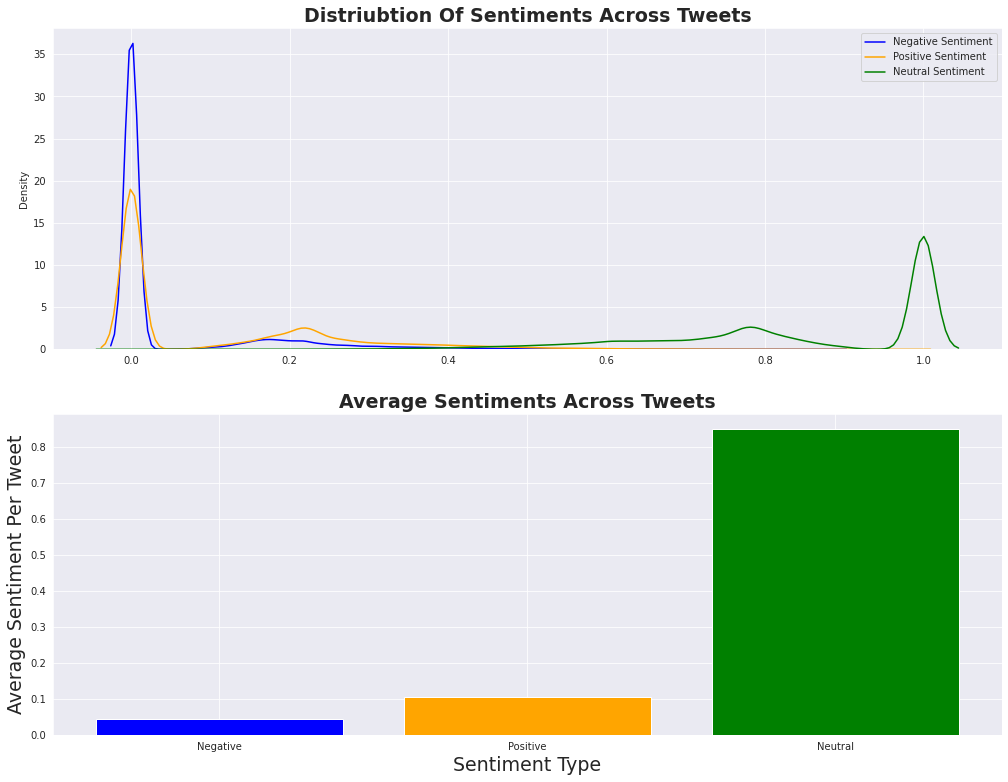

In [133]:

plt.subplot(2,1,1)
plt.title('Distriubtion Of Sentiments Across Tweets',fontsize=19,fontweight='bold')
sns.kdeplot(vaccine_data['Negative Sentiment'], color = 'blue')
sns.kdeplot(vaccine_data['Positive Sentiment'], color = 'orange')
sns.kdeplot(vaccine_data['Neutral Sentiment'], color = 'green')
plt.xlabel(' ')
plt.legend(['Negative Sentiment','Positive Sentiment','Neutral Sentiment'])
plt.subplot(2,1,2)
plt.title('Average Sentiments Across Tweets',fontsize=19,fontweight='bold')
neg_total_avg = (vaccine_data['Negative Sentiment'].sum())/len(vaccine_data.index)
print(neg_total_avg)
pos_total_avg = (vaccine_data['Positive Sentiment'].sum())/len(vaccine_data.index)
print(pos_total_avg)
neu_total_avg = (vaccine_data['Neutral Sentiment'].sum())/len(vaccine_data.index)
print(neu_total_avg)
sentiment_type = ['Negative','Positive','Neutral']
sentiment_total_avg = [neg_total_avg, pos_total_avg, neu_total_avg]
vaccine_data.head()
plt.bar(sentiment_type, sentiment_total_avg, color = ['blue', 'orange', 'green'])
plt.ylabel('Average Sentiment Per Tweet',fontsize=19)
plt.xlabel('Sentiment Type',fontsize=19)
plt.show()

In [134]:
#giving polarity scores based on sentiment analyser 

sid = SIA()

vaccine_data["Positive Sentiment"] = [sid.polarity_scores(i)["pos"] for i in vaccine_data["text"]]
vaccine_data["Neutral Sentiment"] = [sid.polarity_scores(j)["neu"] for j in vaccine_data["text"]]
vaccine_data["Negative Sentiment"] = [sid.polarity_scores(k)["neg"] for k in vaccine_data["text"]]

df1 = vaccine_data[["text", "Positive Sentiment","Neutral Sentiment", "Negative Sentiment"]]

KeyboardInterrupt: 

In [ ]:
# sums of sentiment scores
pos = sum(df1["Positive Sentiment"])
neu = sum(df1["Neutral Sentiment"])
neg = sum(df1["Negative Sentiment"])

# calculates sentiment score
def sentiment_score(pos, neu, neg):
    if (pos>neu) and (pos>neg):
        print("Positive :)")
    elif (neu>pos) and (neu>neg):
        print("Neutral :|")
    else:
        print("Negative :(")     
sentiment_score(pos, neu, neg)

#### Assigning class labels

In [ ]:
# counting positive, neutral and negative tweets
sentiments_nltk = []

for tweet in vaccine_data.text:
     sentiment_dict = sid.polarity_scores(tweet)
     sentiment_dict.pop('compound', None)
     sentiments_nltk.append(max(sentiment_dict , key=sentiment_dict.get))
    
vaccine_data['sentiment_nltk'] = sentiments_nltk
vaccine_data['sentiment_nltk'].value_counts()

#### Exporting the data set to csv

In [ ]:
#exporting dataset with classlabels as csv file. 
# vaccine_data.to_csv('allTweets.csv')
#it is commented because, it is already available for download in the data section

#### training and testing dataset

In [ ]:
#initialising dataset on which trianing is based
X = vaccine_data.text # get all the text in x variable
y = vaccine_data.sentiment_nltk # get all the sentiments into y variable
print(X.shape) #print shape of x
print(y.shape) # print shape of y

In [ ]:
#initialising training and testing dataset 80-20 split
#from sklearn.cross_validation import train_test_split #from sklearn.cross_validation import train_test_split to split the data into training and tesing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 1) # split the data into traing and testing set where ratio is 80:20

In [ ]:
vect = TfidfVectorizer(analyzer = "word", ngram_range=(1,3))

In [ ]:
#transforming data to vector form to feed as input to the models
vect.fit(X_train) # fit or traing data tweets to vect
X_train_dtm = vect.transform(X_train) # transform our training data tweets
X_test_dtm = vect.transform(X_test)# transform our testing data tweets

### SMOTE Analysis

In [ ]:
# Oversample imbalanced dataset with SMOTE
counter = Counter(y_train)
print(counter)

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train_dtm, y_train.ravel())

counter = Counter(y_train_res)
print(counter)

### Random Forest

In [ ]:
#random forest
# randomfor = RandomForestClassifier(n_estimators=200, random_state=0)
# randomfor.fit(X_train_res, y_train_res)
# filename = 'finalized_model_rf.h5'
# pickle.dump(randomfor, open(filename, 'wb'))

In [ ]:
#loading the loaded model that has been saved above
loaded_model_rf = pickle.load(open("../input/trained-models/finalized_model_rf.h5", 'rb'))
#calculating the predicted value from the model
result_rf = loaded_model_rf.predict(X_test_dtm)
# y_pred_lg =randomfor.predict(X_test_dtm)

In [ ]:
#accuracy of the model
print('Model accuracy score with 100 decision-trees : {0:0.4f}\n'. format(metrics.accuracy_score(y_test, result_rf)))

In [ ]:
#classification matrix
print(metrics.classification_report(y_test, result_rf))

In [ ]:
#confusion matrix
print(metrics.confusion_matrix(y_test, result_rf))

In [ ]:
#extracting the misclassified dataset of randomforest as csv
# result = np.vstack((X_test, y_test, y_pred_lg)).T
# result_lg_df = pd.DataFrame(result)
# headers = ["text", "sentiment_nltk", "predicted_sentiment"]
# result_lg_df.columns = headers
# result_lg_df = result_lg_df[result_lg_df['sentiment_nltk'] != result_lg_df['predicted_sentiment']]
# print(result_lg_df)
# result_lg_df.to_csv('lg_misclassified.csv')

### Naive Bayes

In [ ]:
# nb = MultinomialNB(alpha = 10) # get object of Multinomial naive bayes model with alpha parameter = 10
# nb.fit(X_train_res, y_train_res)# fit our both traing data tweets as well as its sentiments to the multinomial naive bayes model
# filename = 'finalized_model_nb.h5'
# pickle.dump(nb, open(filename, 'wb'))
# y_pred_nb =nb.predict(X_test_dtm)

In [ ]:
#loading the loaded random forest model that has been saved above
loaded_model_nb = pickle.load(open("../input/trained-models/finalized_model_nb.h5", 'rb'))
#calculating the predicted value from the model
result_nb = loaded_model_nb.predict(X_test_dtm)

In [ ]:
#accuracy of the model
print('Model accuracy score : {0:0.4f}\n'. format(metrics.accuracy_score(y_test, result_nb)))

In [ ]:
#classification report
print(metrics.classification_report(y_test, result_nb))

In [ ]:
#confusion matrix
print(metrics.confusion_matrix(y_test, result_nb))

In [ ]:
#extracting the misclassified dataset of naive bayes as csv
# result = np.vstack((X_test, y_test, y_pred_nb)).T
# result_nb_df = pd.DataFrame(result)
# headers = ["text", "sentiment_nltk", "predicted_sentiment"]
# result_nb_df.columns = headers
# result_nb_df = result_nb_df[result_nb_df['sentiment_nltk'] != result_nb_df['predicted_sentiment']]
# print(result_nb_df)
# result_nb_df.to_csv('nb_misclassified.csv')

### SVM

In [ ]:
# svm_clf = LinearSVC(random_state=0) # get object of SVC model with random_state parameter = 0
# svm_clf.fit(X_train_dtm, y_train)# fit our both traing data tweets as well as its sentiments to the SVC model
# filename = 'finalized_model_svm.h5'
# pickle.dump(svm_clf, open(filename, 'wb'))
# y_pred_svm = svm_clf.predict(X_test_dtm)  # predict the sentiments of testing data tweets

In [ ]:
#loading the loaded random forest model that has been saved above
loaded_model_svm = pickle.load(open("../input/trained-models/finalized_model_svm.h5", 'rb'))
#calculating the predicted value from the model
result_svm = loaded_model_svm.predict(X_test_dtm)

In [ ]:
#accuracy of the model
print('Model accuracy score : {0:0.4f}\n'. format(metrics.accuracy_score(y_test, result_svm)))

In [ ]:
#classification report
print(metrics.classification_report(y_test, result_svm))

In [ ]:
#confusion matrix
print(metrics.confusion_matrix(y_test, result_svm))

In [ ]:
#extracting the misclassified dataset of svm as csv
# result = np.vstack((X_test, y_test, y_pred_svm)).T
# result_svm_df = pd.DataFrame(result)
# headers = ["text", "sentiment_nltk", "predicted_sentiment"]
# result_svm_df.columns = headers
# result_svm_df = result_svm_df[result_svm_df['sentiment_nltk'] != result_svm_df['predicted_sentiment']]
# print(result_svm_df)
# result_svm_df.to_csv('svm_misclassified.csv')

### Catboost

In [ ]:
# model_CBC = ctb.CatBoostClassifier()
# model_CBC.fit(X_train_dtm, y_train)
# print(model_CBC)
# filename = 'finalized_model_cb.h5'
# pickle.dump(model_CBC, open(filename, 'wb'))
# y_pred_cb = model_CBC.predict(X_test_dtm)

In [ ]:
#loading the loaded random forest model that has been saved above
loaded_model_cb = pickle.load(open("../input/trained-models/finalized_model_cb.h5", 'rb'))
#calculating the predicted value from the model
result_cb = loaded_model_cb.predict(X_test_dtm)

In [ ]:
#accuracy of the model
print('Model accuracy score : {0:0.4f}\n'. format(metrics.accuracy_score(y_test, result_cb)))

In [ ]:
#classification report
print(metrics.classification_report(y_test, result_cb))

In [ ]:
#confusion matrix
print(metrics.confusion_matrix(y_test, result_cb))

## Adding the misclassified data of Naïve Bayes to Other 3 models

In [ ]:
# Reading Data
nb_misclassified_filepath = '../input/misclassified-dataset/nb_misclassified.csv'
nb_misclassified_data = pd.read_csv(nb_misclassified_filepath)
print("Read Complete.")

In [ ]:
# Examining statistics
nb_misclassified_data.describe()

In [ ]:
nb_misclassified_data.head()

In [ ]:
#initialising dataset
X_nb = nb_misclassified_data.text # get all the text in x variable
y_nb = nb_misclassified_data.sentiment_nltk # get all the sentiments into y variable
print(X_nb.shape) #print shape of x
print(y_nb.shape) # print shape of y

In [ ]:
#training testing split 80-20% split
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split #from sklearn.cross_validation import train_test_split to split the data into training and tesing set
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_nb, y_nb, test_size = 0.20, random_state= 1) # split the data into traing and testing set where ratio is 80:20

In [ ]:
vect_nb = TfidfVectorizer(analyzer = "word", ngram_range=(1,3))

In [ ]:
#transforming dataset to give as input to models
vect_nb.fit(X_train_nb) # fit or traing data tweets to vect
X_train_dtm_nb = vect_nb.transform(X_train_nb) # transform our training data tweets
X_test_dtm_nb = vect_nb.transform(X_test_nb)# transform our testing data tweets

In [ ]:
# Oversample imbalanced dataset with SMOTE
counter_nb = Counter(y_train_nb)
print(counter_nb)

sm = SMOTE(random_state=2)
X_train_res_nb, y_train_res_nb = sm.fit_resample(X_train_dtm_nb, y_train_nb.ravel())

counte_nbr = Counter(y_train_res_nb)
print(counter_nb)

In [ ]:
#random forest
# randomfor_nb = RandomForestClassifier(n_estimators=200, random_state=0)

In [ ]:
#fiting random forest model
# randomfor_nb.fit(X_train_res_nb, y_train_res_nb)

In [ ]:
#saving model for future use
# filename = 'rf_model.h5'
# pickle.dump(randomfor_nb, open(filename, 'wb'))

In [ ]:
#loading the loaded random forest model that has been saved above
loaded_model_rf_nb = pickle.load(open("../input/misclassified-models/rf_model.h5", 'rb'))
#calculating the predicted value from the model
result_rf_nb = loaded_model_rf_nb.predict(X_test_dtm_nb)

In [ ]:
#predicted value if we train model fresh
# y_pred_lg_nb =randomfor_nb.predict(X_test_dtm_nb)

In [ ]:
#giving the model accuracy
print('Model accuracy score : {0:0.4f}\n'. format(metrics.accuracy_score(y_test_nb, result_rf_nb)))

In [ ]:
#classification report
print(metrics.classification_report(y_test_nb, result_rf_nb))

In [ ]:
#confusion matrix
print(metrics.confusion_matrix(y_test_nb, result_rf_nb))

In [ ]:
# svm_clf_nb = LinearSVC(random_state=0) # get object of SVC model with random_state parameter = 0

In [ ]:
#the model that has to be trained 
# svm_clf_nb.fit(X_train_dtm_nb, y_train_nb)# fit our both traing data tweets as well as its sentiments to the SVC model

In [ ]:
# saving the model for future use, so we don't have to keep training the model.
# filename = 'svm_model.h5'
# pickle.dump(svm_clf_nb, open(filename, 'wb'))

In [ ]:
#loading the loaded svm model that has been saved above
loaded_model_svm_nb = pickle.load(open("../input/misclassified-models/svm_model.h5", 'rb'))
#calculating the predicted value from the model
result_svm_nb = loaded_model_svm_nb.predict(X_test_dtm_nb)

In [ ]:
#giving the model accuracy
print('Model accuracy score : {0:0.4f}\n'. format(metrics.accuracy_score(y_test_nb, result_svm_nb)))

In [ ]:
#classification report
print(metrics.classification_report(y_test_nb, result_svm_nb))

In [ ]:
#confusion matrix
print(metrics.confusion_matrix(y_test_nb, result_svm_nb))

In [ ]:
# y_pred_svm_nb = svm_clf.predict(X_test_dtm_nb)  # predict the sentiments of testing data tweets

In [ ]:
#training the model 
# model_CBC_nb = ctb.CatBoostClassifier()
# model_CBC_nb.fit(X_train_dtm_nb, y_train_nb)
# print(model_CBC_nb)

In [ ]:
#saving the model for future use
# filename = 'cb_model.h5'
# pickle.dump(randomfor, open(filename, 'wb'))

In [ ]:
#loading the loaded catboost model that has been saved above
loaded_model_cb_nb = pickle.load(open('../input/misclassified-models/cb_model.h5', 'rb'))
#calculating the predicted value from the model
result_cb_nb = loaded_model_cb_nb.predict(X_test_dtm_nb)

In [ ]:
# predicted_y = model_CBC.predict(X_test_dtm)

In [ ]:
#giving the model accuracy
print('Model accuracy score : {0:0.4f}\n'. format(metrics.accuracy_score(y_test_nb, result_cb_nb)))

In [ ]:
#classification report
print(metrics.classification_report(y_test_nb, result_cb_nb))

In [ ]:
#confusion matrix
print(metrics.confusion_matrix(y_test_nb, result_cb_nb))